<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%5B10%5D%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시계열(time-series) 데이터 분석

In [2]:
## 라이브러리 불러오기
import pandas as pd; import numpy as np;import matplotlib.pyplot as plt
from keras.models import Sequential; from keras.layers import LSTM, Dropout, Dense, Activation;import datetime


Using TensorFlow backend.


# 삼성전자 주가를 예측하여 보자
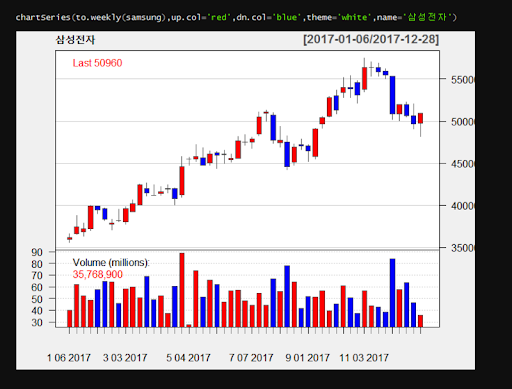


In [3]:
!git clone https://github.com/hongjai-rhee/public.git
## 깃허브 디렉토리 마운트
dat = pd.read_csv('/content/public/stock.csv')  ## 1125일 동안 삼성전자 주가 데이터

dat.head(10)  

Cloning into 'public'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 498 (delta 64), reused 58 (delta 18), pack-reused 353
Receiving objects: 100% (498/498), 49.39 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (242/242), done.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700,30000,29680,30000,41.274914,10588400
1,2013-10-31,29960,30040,29300,29300,40.311840,12647050
2,2013-11-01,29800,30000,29360,30000,41.274914,11357700
3,2013-11-04,29840,30040,29780,29980,41.247398,10887800
4,2013-11-05,30040,30040,29440,29700,40.862167,8009300
5,2013-11-06,29960,29960,28980,29020,39.926601,12218400
6,2013-11-07,29020,29080,28500,28740,39.541370,13006800
7,2013-11-08,28220,28560,28140,28200,38.798420,13681350
8,2013-11-11,28500,28680,28180,28560,39.293724,8563850
9,2013-11-12,28800,29320,28720,29120,40.064182,9784900


# 분석대상 가격과 윈도우 결정
종가를 기준으로 분석하려고 한다. 
최근 50일간(window)의 주가가 다음 날짜의 주가에 영향을 준다고 가정하자. 

 


In [4]:
prices = dat['Close'].values
window = 50
sequence_length = window + 1

result = []
for index in range(len(prices) - sequence_length):
    result.append(prices[index: index + sequence_length])
print(prices[0:51])

[30000 29300 30000 29980 29700 29020 28740 28200 28560 29120 28380 28480
 29240 29480 29780 29400 28800 29000 29300 29580 29400 29880 29880 29340
 29220 28640 28800 28560 29080 28800 28400 28200 27800 28000 27900 28020
 28540 28540 28660 28300 28160 27920 27440 26180 25920 26140 26080 25820
 25500 25440 25900]


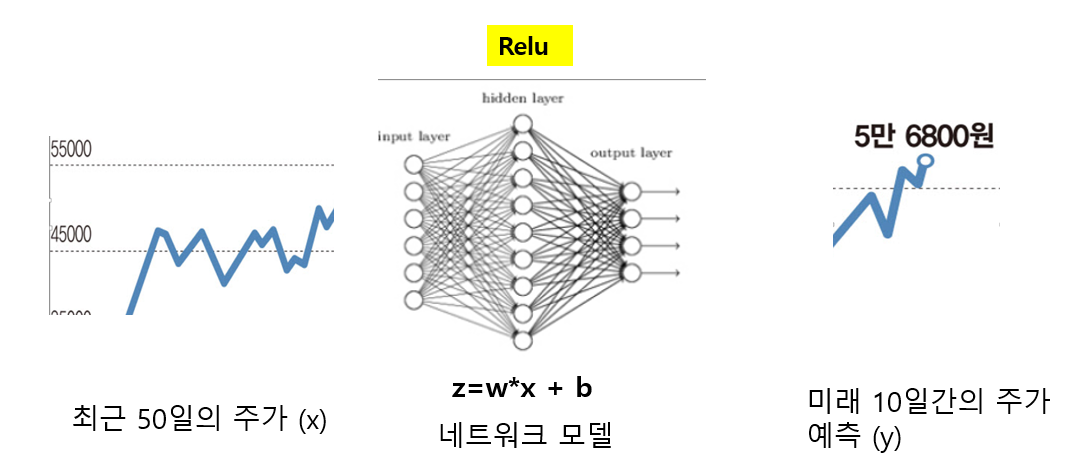

# 데이터 정규화 (optional).  

In [5]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, y_train.shape

((1057, 50, 1), (1057,))

# 예측문제 시각화: 
X(50개의 과거 주가)를 보고 Y(내일의 주가)를 예측
 

x[0]=
[[ 0.      0.0188  0.0233  0.0377  0.035   0.0224  0.0224 -0.0099  0.0143
   0.035   0.0215 -0.0126 -0.0323 -0.0323 -0.043  -0.043  -0.0305 -0.0233
  -0.0269 -0.0224  0.0063  0.0126 -0.0027  0.0143  0.0287  0.017   0.
   0.0081  0.0072  0.0332  0.0377  0.0673  0.0314  0.0269  0.0143  0.0099
  -0.0027  0.017   0.017   0.0036  0.      0.0323  0.122   0.139   0.13
   0.1229  0.1247  0.1381  0.1345  0.1265]]

y[0]= 0.1354


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

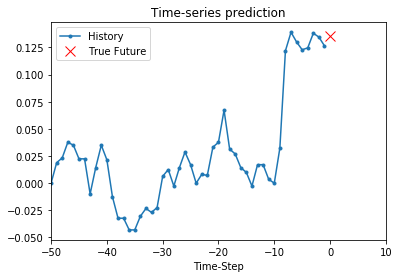

In [6]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt
print('x[0]=')
print(np.round(np.transpose(x_train[0]),4))
print()
print('y[0]=',np.round(np.transpose(y_train[0]),4))
show_plot([x_train[0], y_train[0]], 0, 'Time-series prediction')

# 모형 설정
Time Series에 특화된 LSTM 모델을 사용한다. LSTM은 RNN의 일종이다.



In [7]:
model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(6, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 10)            480       
_________________________________________________________________
lstm_2 (LSTM)                (None, 6)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 895
Trainable params: 895
Non-trainable params: 0
_________________________________________________________________


# 학습하기

In [8]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1057 samples, validate on 117 samples
Epoch 1/5





1057/1057 [==============================] - 27s 26ms/step - loss: 0.0011 - val_loss: 8.3710e-04
Epoch 2/5
1057/1057 [==============================] - 17s 16ms/step - loss: 8.2266e-04 - val_loss: 7.6810e-04
Epoch 3/5
1057/1057 [==============================] - 16s 16ms/step - loss: 7.4417e-04 - val_loss: 5.7237e-04
Epoch 4/5
1057/1057 [==============================] - 17s 16ms/step - loss: 7.0345e-04 - val_loss: 6.5094e-04
Epoch 5/5
1057/1057 [==============================] - 16s 15ms/step - loss: 6.5398e-04 - val_loss: 7.5313e-04


# 학습된 모형의 예측성능 시각화

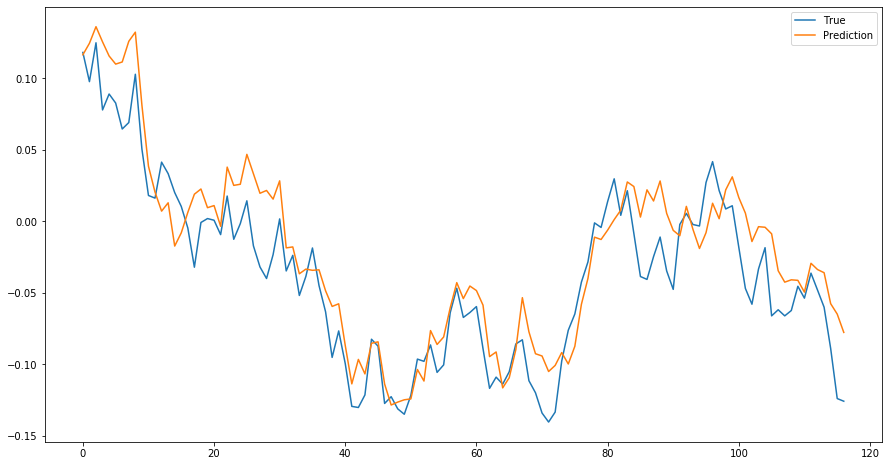

In [9]:

pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

# Attention!
실제로 맞지 않는 경우가 많습니다. shock이나 내부정보는 알지 못합니다. 
주식은 사실 사람의 심리와 밀접한 관계가 있습니다. 

---


매일 매일, 욕망에 이끌려 사는 투자자들의 변화무쌍한 심리상태를 측정할수 있을까요?

---




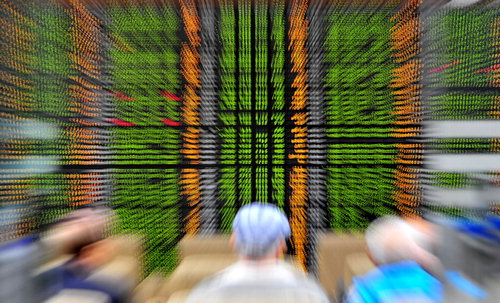

# 비디오는 이미지의 타임시리즈이다. 데이터의 구조를 살펴보자.

https://www.youtube.com/watch?v=Mll-G7ADTgo




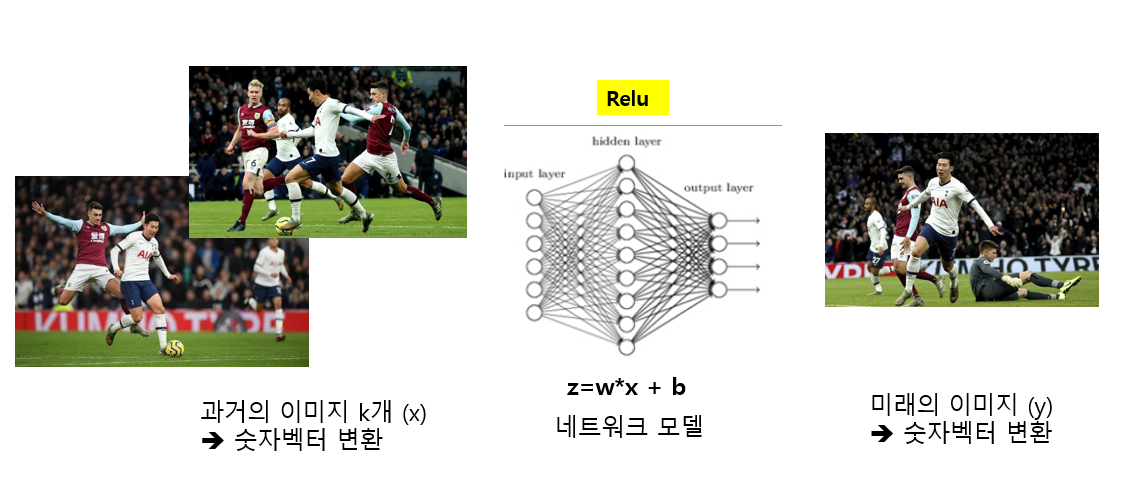

# 영화를 반쯤만 보고 남아 있는 스토리를 알아낼수 있을까? ㅎ
데이터의 복잡성 덕분에 기계학습에 가장 적합한 데이터는 이미지(CNN)나 비디오(RNN)이다. 